<a href="https://colab.research.google.com/github/omini12/teste/blob/master/Detector_de_passsaros_opencv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importar biblioteca

In [ ]:
import cv2
cv2.__version__

'4.1.2'

In [ ]:
!pip install Image
!pip install TAGS
!pip install opencv-python==4.4.0.40

     |████████████████████████████████| 7.9 MB 5.2 MB/s 
  Created wheel for Image: filename=image-1.5.33-py2.py3-none-any.whl size=19496 sha256=1b0346bdb31e701777dcf897c4790c992c18960e98a69c4d81f3dde25a899821
  Stored in directory: /root/.cache/pip/wheels/56/88/e6/897194cfe8c08a8b9afd881d3bf53d102e13fa39607d721383
Successfully built Image
  Created wheel for TAGS: filename=tags-0.0.1-py3-none-any.whl size=5658 sha256=0ca1537a49724327ad8ff7f8396a11f6dfde335f0d075887f77e343ea46852c3
  Stored in directory: /root/.cache/pip/wheels/cc/a2/77/da5d8116d6a19a24e346494caf670f246d4b2022c0d30c4059
Successfully built TAGS
     |████████████████████████████████| 49.4 MB 329 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source

In [ ]:
import cv2
import numpy as np 
import time
import os 
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import zipfile 
from PIL import Image 
from PIL.ExifTags import TAGS 
cv2.__version__

'4.4.0'

#Conectar ao google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Modelo de treinamento 

In [ ]:
path = '/content/gdrive/MyDrive/Imagens_mestrado/modelo_YOLOv4.zip'
zip_object = zipfile.ZipFile(file=path , mode='r')
zip_object.extractall('./')
zip_object.close()
label_path =  os.path.sep.join(['/content/cfg', 'coco.names'])
LABELS = open(label_path).read().strip().split('\n')
weights_path =  os.path.sep.join(['/content', 'yolov4.weights'])
config_path =  os.path.sep.join(['/content/cfg', 'yolov4.cfg'])
net = cv2.dnn.readNet(config_path,weights_path)

#configurações de detecção


In [ ]:
COLORS = np.random.randint(0,255, size=(len(LABELS), 3), dtype='uint8')
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

#Imagens para pré treinar o modelo

In [ ]:
def mostrar(img):
  fig = plt.gcf()
  fig.set_size_inches(16,10)
  plt.axis('off')
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

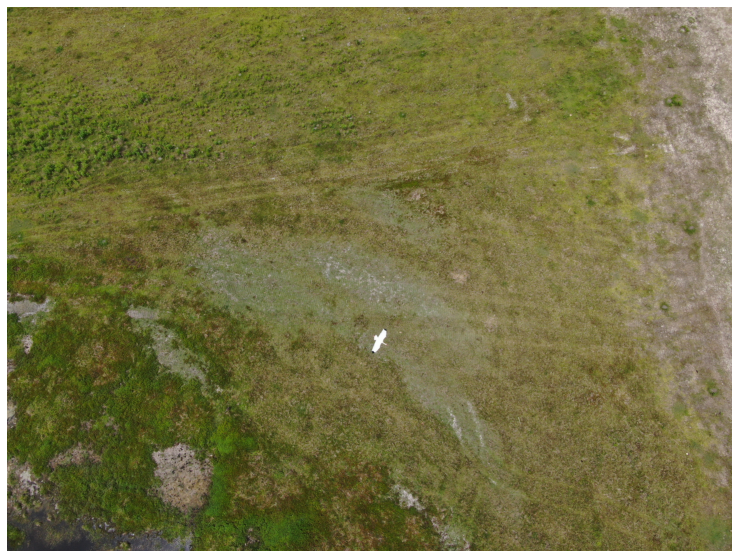

In [ ]:
path_imagem = '/content/gdrive/MyDrive/Imagens_mestrado/DJI_0093.JPG'
imagem = cv2.imread(path_imagem)
mostrar(imagem)

In [ ]:
def blob_imagem(net, imagem, mostrar_texto=True):
  inicio = time.time()

  blob = cv2.dnn.blobFromImage(imagem, 1/255.0, (416, 416), swapRB = True, crop = False)
  net.setInput(blob)
  layerOutputs = net.forward(ln)

  termino = time.time()
  
  if mostrar_texto:
    print('YOLO levou {:.2f} segundos'.format(termino - inicio))
  return net, imagem, layerOutputs

In [ ]:
net, imagem, layerOutputs = blob_imagem(net, imagem)
_threshold = 0.5
_threshold_NMS = 0.3
caixas = []
confiancas = []
IDclasses = []
(H, W) = imagem.shape[:2]

YOLO levou 2.14 segundos


In [ ]:
def deteccoes(detection, _threshold, caixas, confiancas, IDclasses):
    scores = detection[5:]
    classeID = np.argmax(scores)
    confianca = scores[classeID]

    if confianca > _threshold:
      caixa = detection[0:4] * np.array([W, H, W, H])
      (centerX, centerY, width, height) = caixa.astype('int')
      x = int(centerX - (width / 2))
      y = int(centerY - (height / 2))

      caixas.append([x, y, int(width), int(height)])
      confiancas.append(float(confianca))
      IDclasses.append(classeID)
    return caixas, confiancas, IDclasses

In [ ]:
for output in layerOutputs:
  for detection in output:
      caixas, confiancas, IDclasses = deteccoes(detection, _threshold, caixas, confiancas, IDclasses)

In [ ]:
objs = cv2.dnn.NMSBoxes(caixas, confiancas, _threshold, _threshold_NMS)
confiancas[0]

0.7906196713447571

In [ ]:
def funcoes_imagem (imagem, i , confiancas, caixas, COLORS, LABELS, mostrar_texto=True):
      (x,y) = (caixas[i][0], caixas[i][1])
      (w,h) = (caixas[i][2], caixas[i][3])
      cor = [int(c) for c in COLORS[IDclasses[i]]]
      cv2.rectangle(imagem, (x , y), (x + w, y + h), cor, 2)
      objeto = imagem_cp[y:y + h , x:x + w]
      texto = "{}: {:.4f}".format(LABELS[IDclasses[i]], confiancas[i])
      if mostrar_texto:
        print(">" + texto)
        print(x,y,w,h)
      cv2.putText(imagem, texto, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, cor, 3)
 

      return imagem,x,y,w,h

#Detecção em multiplas imagens 


**Imagens de teste**


In [ ]:
path = '/content/gdrive/MyDrive/Imagens_mestrado/imagens_teste_passaros.zip'
zip_object = zipfile.ZipFile(file=path , mode='r')
zip_object.extractall('./imagens_teste_passaros')
zip_object.close()
diretorio_fotos = 'imagens_teste_passaros'
caminhos  = [os.path.join(diretorio_fotos, f) for f in os.listdir(diretorio_fotos)]



**FINAL**

In [ ]:
path = '/content/gdrive/MyDrive/Imagens_mestrado/voo_teste.zip'
zip_object = zipfile.ZipFile(file=path , mode='r')
zip_object.extractall('./imagens_voo_teste')
zip_object.close()
diretorio_fotos = 'imagens_voo_teste'
caminhos  = [os.path.join(diretorio_fotos, f) for f in os.listdir(diretorio_fotos)]

YOLO levou 1.75 segundos
YOLO levou 1.94 segundos
YOLO levou 1.72 segundos
YOLO levou 1.73 segundos
YOLO levou 1.71 segundos


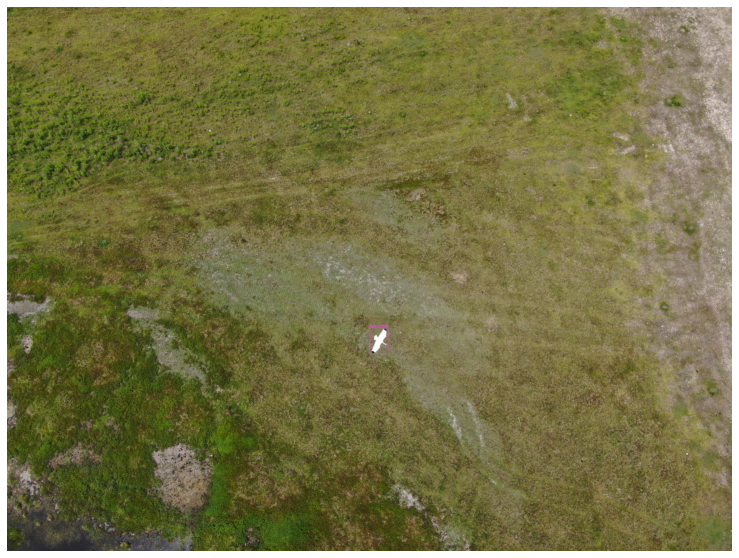

Total de passaros detectados: 1


In [ ]:
contagem_total = 0
arquivo = open("Relatorio de campo.txt", "w")
arquivo.write("ID Imagem Localização  Lat/Long Data/Hora\n")
arquivo.close()


for caminho_imagem in caminhos:
  try:
    imagem = cv2.imread(caminho_imagem)
    (H, W) = imagem.shape[:2]
  except:
    print('Erro ao carregar a imagem ->  ' + caminho_imagem)
    continue
  imagem_cp = imagem.copy()
  net, imagem, layerOutputs = blob_imagem(net, imagem)
  

  caixas = []
  confiancas = []
  IDclasses = []


  contagem = 0

  for output in layerOutputs:
    for detection in output:
      caixas, confiancas, IDclasses = deteccoes(detection, _threshold, caixas, confiancas, IDclasses)
  objs = cv2.dnn.NMSBoxes(caixas, confiancas, _threshold, _threshold_NMS)

  if len(objs) > 0:
    for i in objs.flatten():
      if LABELS[IDclasses[i]] == 'bird':
          contagem += 1
          contagem_total = contagem_total + 1
          
          image2 = Image.open(caminho_imagem) 
          exifdata = image2.getexif() 
          nome_da_imagem = os.path.basename(path_imagem)

          for tagid in exifdata:
           tagname = TAGS.get(tagid, tagid)
           value = exifdata.get(tagid) 


           if tagname == "DateTime":
             arquivo = open("Relatorio de campo.txt", "a")
             arquivo.writelines(value)
             arquivo.close()


           if tagname == "GPSInfo":
             grau, min, s = value[2]
             grau2,min2,s2 = value[4]
             animal=LABELS[i]
             #print(grau[0],min[0],s[0],grau2[0],min2[0],s2[0])

             #print('Latitute :{} {} {} {} e Longitude:{} {} {} {} ' .format( value[1], grau[0], min[0], s[0], value[3], grau2[0], min2[0],s2[0]))
             arquivo = open("Relatorio de campo.txt", "a")
             arquivo.write(' {} {} {} {}°{},{} / {} {}°{},{} ' .format( LABELS[14],caminho_imagem,value[1], grau[0], min[0], s[0], value[3], grau2[0], min2[0],s2[0]))
             arquivo.close()
          



          imagem, x, y, w, h = funcoes_imagem(imagem, i , confiancas, caixas, COLORS, LABELS, mostrar_texto=False)
          objeto = imagem_cp[y:y + h , x:x + w]  
          mostrar(imagem)
      

print('Total de passaros detectados: ' + str(contagem_total))